Plotting Selected MIMIC metrics (without training time)...

Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en Selected_MIMIC_Models
                         ModGPT2  ModGPT2NOMASK  ModGPT2HIDDEN  ModGPT2DINO  ModGPT2NOMASKDINO  ModGPT2HIDDENDINO
chexbert_f1_weighted      0.2613         0.1214         0.2134       0.2838             0.2162             0.2520
chexbert_f1_micro         0.3159         0.1696         0.2773       0.3328             0.2489             0.3530
chexbert_f1_macro         0.1697         0.0715         0.1341       0.1718             0.1270             0.1522
chexbert_f1_micro_5       0.3370         0.1368         0.2394       0.3710             0.3364             0.3930
chexbert_f1_macro_5       0.2383         0.0832         0.1811       0.2692             0.2505             0.2363
radgraph_f1_RG_E          0.1609         0.1466         0.1578       0.1717             0.1888             0.1722
radgraph_f1_RG_ER         0.1509         0.1314        

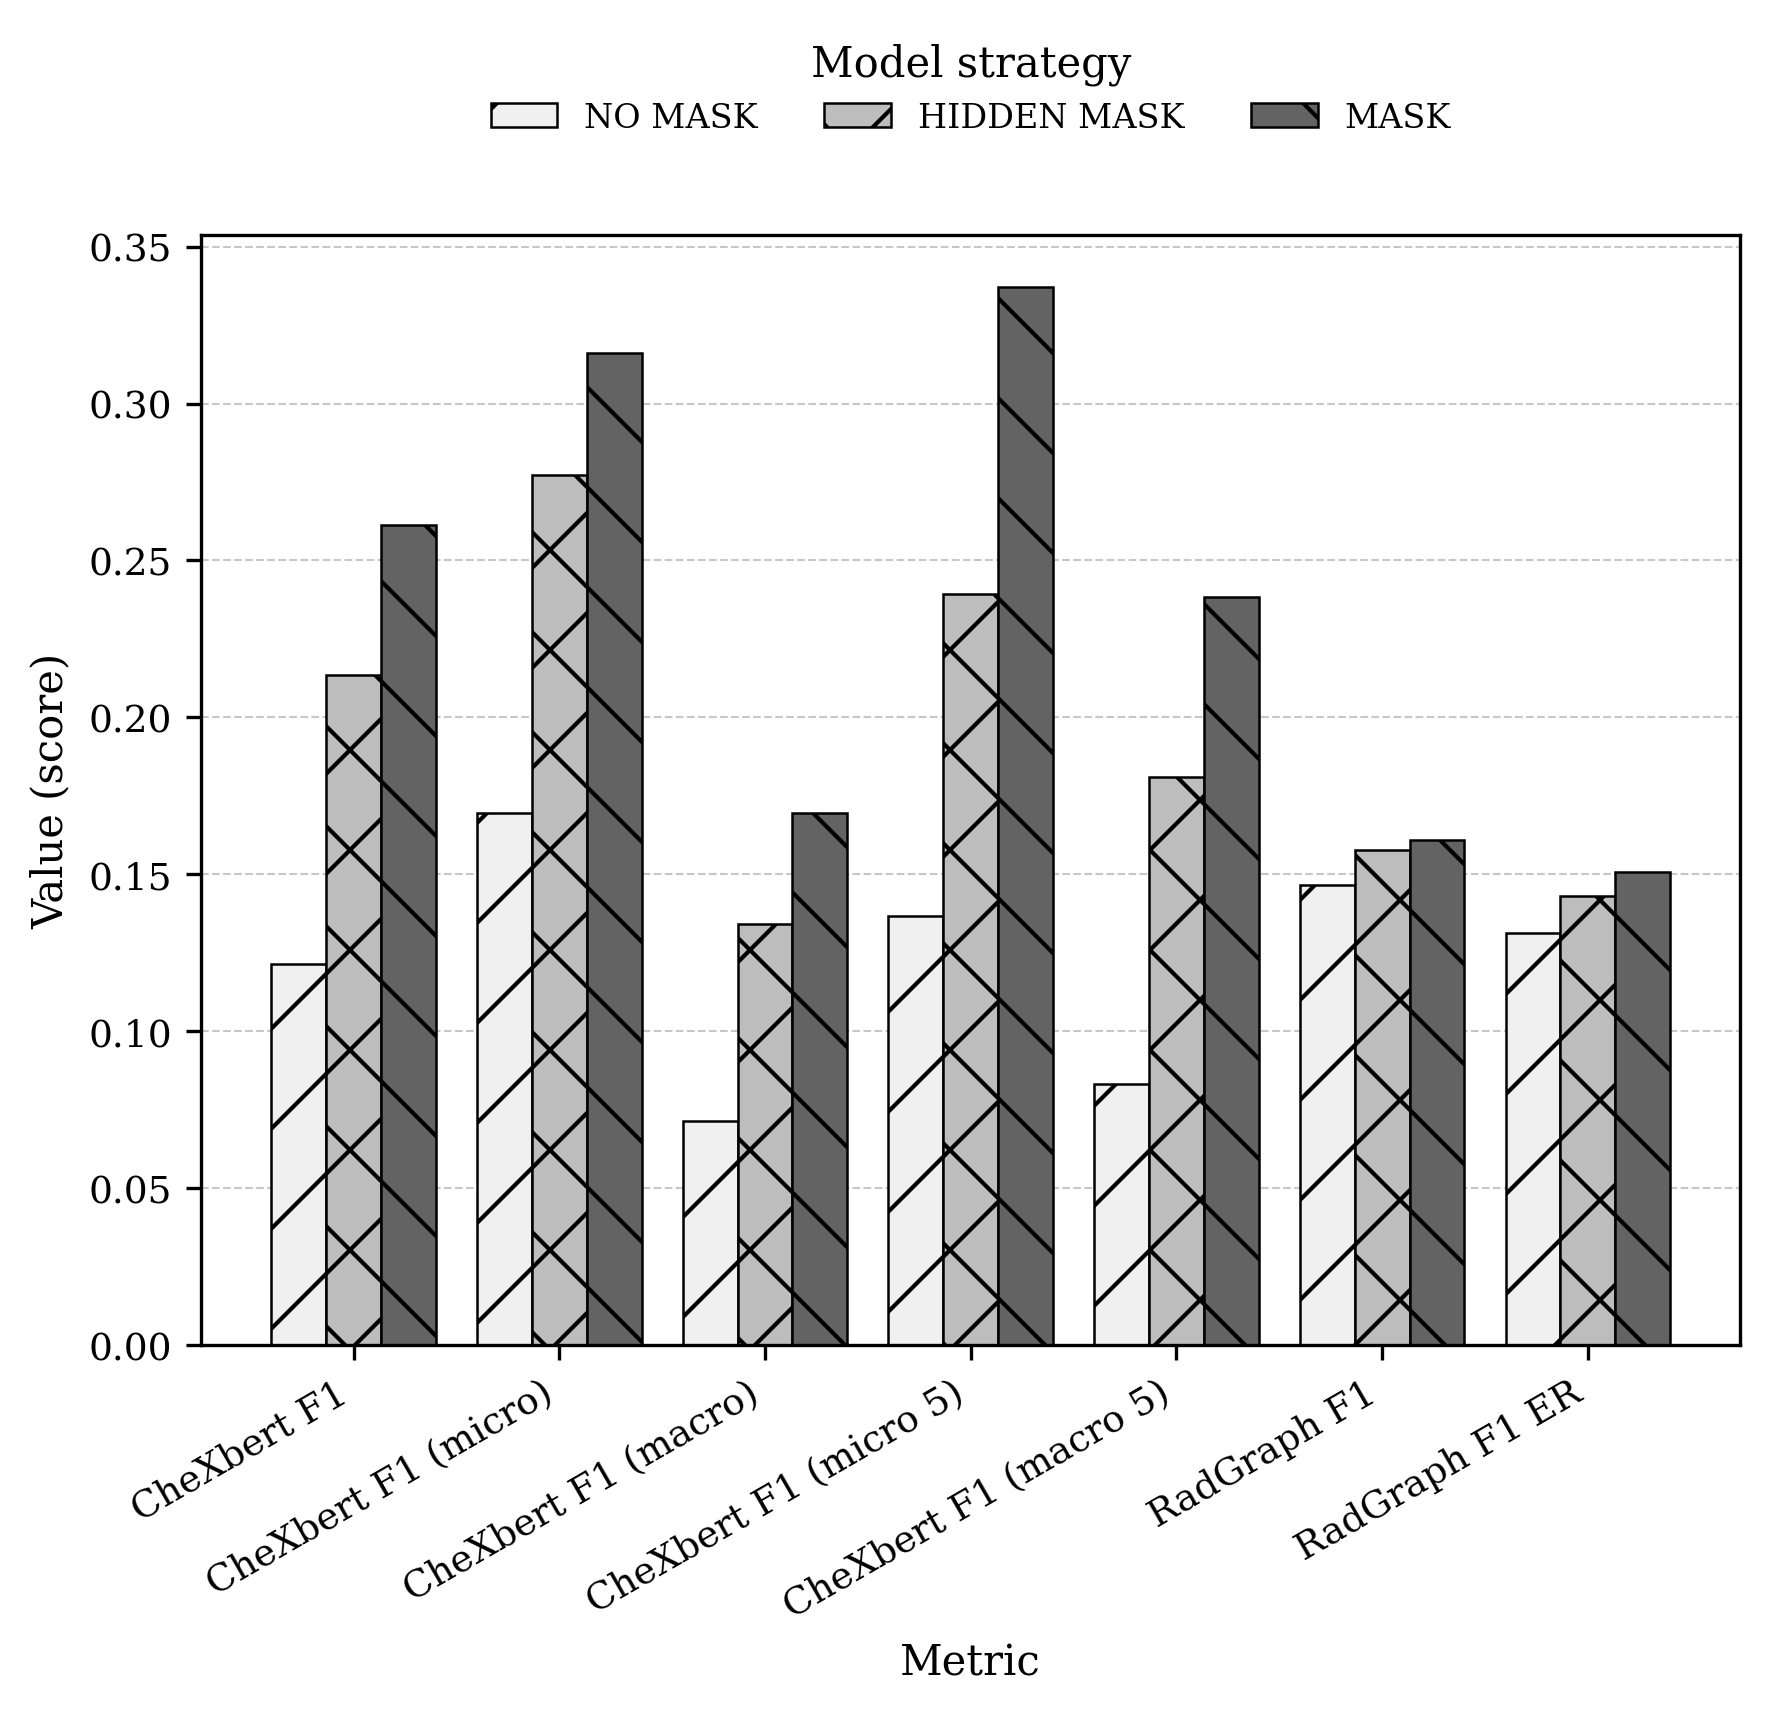

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")  # Suppress unnecessary warnings for cleaner output


# ============================================================
# 1. DATA PREPARATION
# ============================================================

def prepare_for_bar_plot(df_original, dataset_name):
    """
    Selects, renames, and formats the metrics for plotting a grouped bar chart 
    where metrics are on the X-axis.

    Args:
        df_original (pd.DataFrame): DataFrame where Metrics are Index (Rows), Models are Columns.
        dataset_name (str): Name of the dataset for context.
        
    Returns:
        pd.DataFrame: DataFrame ready for plotting (Index=Metrics, Columns=Models).
    """

    # --- Map REAL metric keys -> pretty labels for plotting ---
    # keys MUST match df_original.index exactly
    # Training time is intentionally excluded
    metric_map = {
        "chexbert_f1_weighted": "CheXbert F1",
        "chexbert_f1_micro":    "CheXbert F1 (micro)",
        "chexbert_f1_macro":    "CheXbert F1 (macro)",
        "chexbert_f1_micro_5":  "CheXbert F1 (micro 5)",
        "chexbert_f1_macro_5":  "CheXbert F1 (macro 5)",
        "radgraph_f1_RG_E":     "RadGraph F1",
        "radgraph_f1_RG_ER":    "RadGraph F1 ER",
    }

    # Keep only the metrics that are actually present in df_original
    metrics_to_plot = [k for k in metric_map.keys() if k in df_original.index]

    if not metrics_to_plot:
        print("No matching metrics found to plot. Check metric_map keys vs df_original.index.")
        print("df_original.index:", df_original.index.tolist())
        return df_original

    # Select in the desired order and rename to pretty labels
    df_plot = df_original.loc[metrics_to_plot]
    df_plot = df_plot.rename(index=metric_map)

    # Metrics stay in index, models in columns
    return df_plot


# ============================================================
# 2. PLOTTING FUNCTION (TECHNICAL PAPER STYLE)
# ============================================================

def plot_model_metrics(data_dict, dataset_name):
    """
    Creates a grouped bar chart in technical paper format and prints a formatted Pandas table.
    Each metric (excluding training time) is on the x-axis with grouped bars for each model.
    """
    if not data_dict:
        print(f"No data to plot for {dataset_name}.")
        return

    # --- Global style for technical-paper figures ---
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 10,
        "legend.fontsize": 8,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "figure.dpi": 300,
    })

    # Dictionary -> DataFrame (outer keys = models, inner keys = metrics)
    df_original = pd.DataFrame(data_dict)

    # Prepare data for the Bar Chart: filter/rename metrics (NO training time)
    df_for_plot = prepare_for_bar_plot(df_original.copy(), dataset_name)

    # ------------------------------------------------------------
    # Tabular results (full, including training time if present)
    # ------------------------------------------------------------
    print("\n" + "=" * 80)
    print(f"Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en {dataset_name}")
    print("=" * 80)
    df_formatted = df_original.round(4)
    print(df_formatted.to_string())
    print("=" * 80 + "\n")

    # If prepare_for_bar_plot returned something empty
    if df_for_plot is None or df_for_plot.empty:
        print("Prepared DataFrame for plot is empty.")
        return

    # ------------------------------------------------------------
    # Manual grouped bar plot to ensure ALL (non-time) metrics appear
    # ------------------------------------------------------------

    # Map model names to simplified names for the legend
    model_rename_map = {
        'ModGPT2NOMASK': 'NO MASK',
        'ModGPT2HIDDEN': 'HIDDEN MASK',
        'ModGPT2':       'MASK',
        # add more if you want to compare DINO variants too
        # 'ModGPT2DINO': 'MASK + DINO',
        # 'ModGPT2NOMASKDINO': 'NO MASK + DINO',
        # 'ModGPT2HIDDENDINO': 'HIDDEN MASK + DINO',
    }

    # Desired order of models: NO MASK, HIDDEN MASK, MASK
    model_order = ['ModGPT2NOMASK', 'ModGPT2HIDDEN', 'ModGPT2']

    # Filter and reorder columns (models) for plotting
    available_models = [m for m in model_order if m in df_for_plot.columns]
    if not available_models:
        print("No matching models found in data for plotting.")
        print("Available columns:", df_for_plot.columns.tolist())
        return

    df_plot_filtered = df_for_plot[available_models].rename(columns=model_rename_map)

    metrics = df_plot_filtered.index.tolist()        # x-axis categories
    model_labels = df_plot_filtered.columns.tolist() # bars per metric (now in desired order)

    n_metrics = len(metrics)
    n_models = len(model_labels)

    # x positions for each metric group
    x = np.arange(n_metrics)
    total_width = 0.8
    bar_width = total_width / n_models

    # Figure size ~ single-column paper figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # Grayscale + hatching (print friendly)
    gray_colors = ['#f0f0f0', '#bdbdbd', '#636363']
    hatches = ['/', 'x', '\\']  # 3 patterns for the 3 models

    # Plot each model set
    for i, model in enumerate(model_labels):
        offset = (i - (n_models - 1) / 2) * bar_width
        values = df_plot_filtered[model].values

        bars = ax.bar(
            x + offset,
            values,
            width=bar_width,
            label=model,
            edgecolor='black',
            linewidth=0.6,
            color=gray_colors[i % len(gray_colors)]
        )

        for b in bars:
            b.set_hatch(hatches[i % len(hatches)])

    # Axes / ticks
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value (score)')
    ax.set_xticks(x)
    # Rotate labels so they don’t overlap
    ax.set_xticklabels(metrics, rotation=30, ha='right')

    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)
    ax.set_ylim(bottom=0)

    # Legend above the plot
    ax.legend(
        title='Model strategy',
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.20),
        ncol=n_models
    )

    plt.tight_layout()

    # Save in paper-ready formats
    safe_name = dataset_name.replace(" ", "_")
    png_path = f"assets/barplot_{safe_name}.png"
    plt.savefig(png_path, bbox_inches='tight')
    print(f"Figure saved as: {png_path}")

    plt.show()


# ============================================================
# 3. LOAD JSON RESULTS AND CALL PLOT
# ============================================================

json_paths_folder = "lstm-vs-gpt/results_complete"

# Selected files
selected_json_files = [
    'ModGPT2_20_MIMIC.json',
    'ModGPT2NOMASK_20_MIMIC.json',
    'ModGPT2HIDDEN_20_MIMIC.json',
    'ModGPT2DINO_20_MIMIC.json',
    'ModGPT2NOMASKDINO_20_MIMIC.json',
    'ModGPT2HIDDENDINO_20_MIMIC.json'
]

selected_model_names = [f.split('_')[0] for f in selected_json_files]
values_selected_mimic = {}

for i in range(len(selected_model_names)):
    model_name = selected_model_names[i]
    file_path = os.path.join(json_paths_folder, selected_json_files[i])
    try:
        with open(file_path, 'r') as f:
            values_selected_mimic[model_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

print("Plotting Selected MIMIC metrics (without training time)...")
plot_model_metrics(values_selected_mimic, "Selected_MIMIC_Models")


Plotting Chexpert metrics...
Convirtiendo training_time_seconds a horas/5 epochs para Chexpert...

Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en Chexpert
                         BiLSTM      GPT2        GPT      LSTM  MAIRA2  ModGPT2DINO  ModGPT2HIDDENDINO  ModGPT2HIDDEN  ModGPT2NOMASKDINO  ModGPT2NOMASK    ModGPT2
chexbert_f1_weighted     0.0000    0.0000     0.0000    0.0000   0.507       0.0686             0.3362         0.2286             0.0652         0.2160     0.1945
chexbert_f1_micro        0.0000    0.0000     0.0000    0.0000   0.581       0.0845             0.4211         0.3577             0.1818         0.3243     0.2921
chexbert_f1_macro        0.0000    0.0000     0.0000    0.0000   0.416       0.0431             0.1987         0.1310             0.0479         0.1188     0.1025
chexbert_f1_micro_5      0.0000    0.0000     0.0000    0.0000   0.591       0.0000             0.4086         0.3590             0.2540         0.3030     0.2400
chexbert_f1_

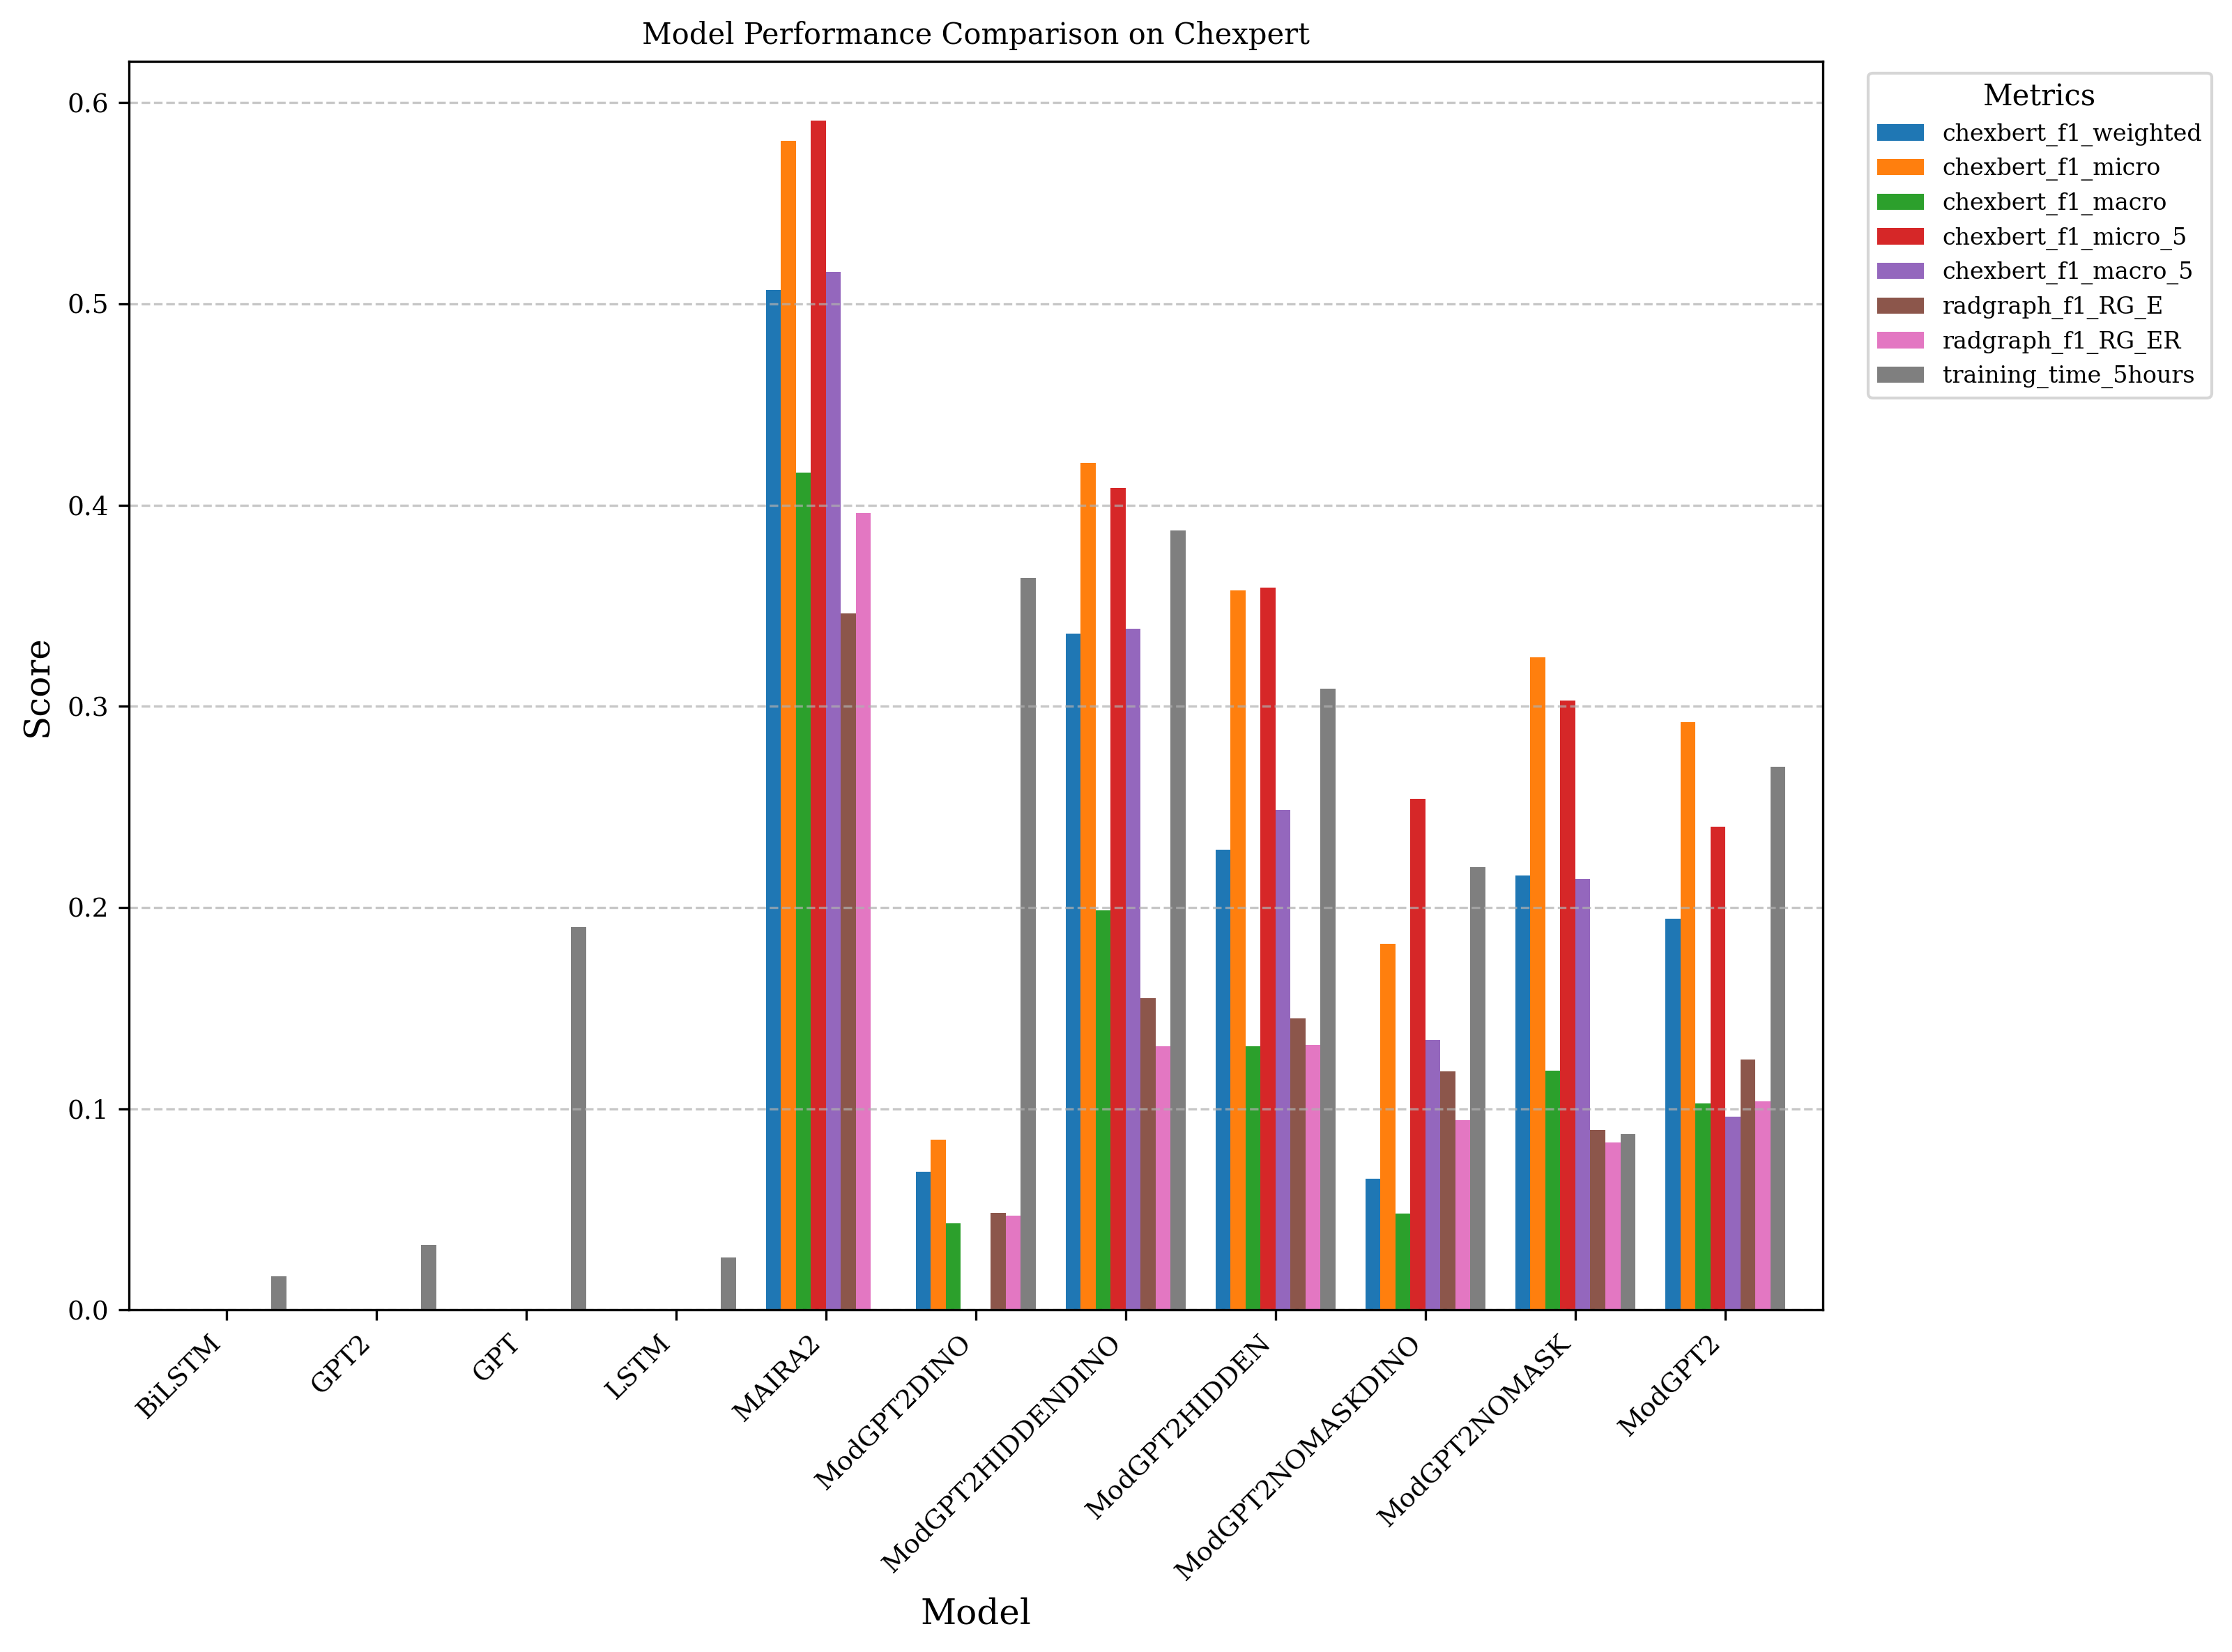

Plotting MIMIC metrics...
Convirtiendo training_time_seconds a horas/5 epochs para MIMIC...

Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en MIMIC
                       cloudbestmodel10    LSTM  MAIRA2  ModGPT2BOTHDATA99  ModGPT2BOTHDATADINO200EP  ModGPT2BOTHDATADINO40EP  ModGPT2BOTHDATADINO  ModGPT2BOTHDATAHIDDENDINO  ModGPT2BOTHDATANOMASK  ModGPT2BOTHDATA  ModGPT2DINO  ModGPT2HIDDENDINO  ModGPT2HIDDEN  ModGPT2NOMASKDINO  ModGPT2NOMASK    ModGPT2
chexbert_f1_weighted             0.3333  0.5515   0.507             0.1480                    0.3530                   0.3598               0.3457                     0.3121                 0.2971           0.3210       0.2838             0.2520         0.2134             0.2162         0.1214     0.2613
chexbert_f1_micro                0.3838  0.2219   0.581             0.2240                    0.3703                   0.3746               0.3613                     0.3257                 0.3117           0.3531       0.33

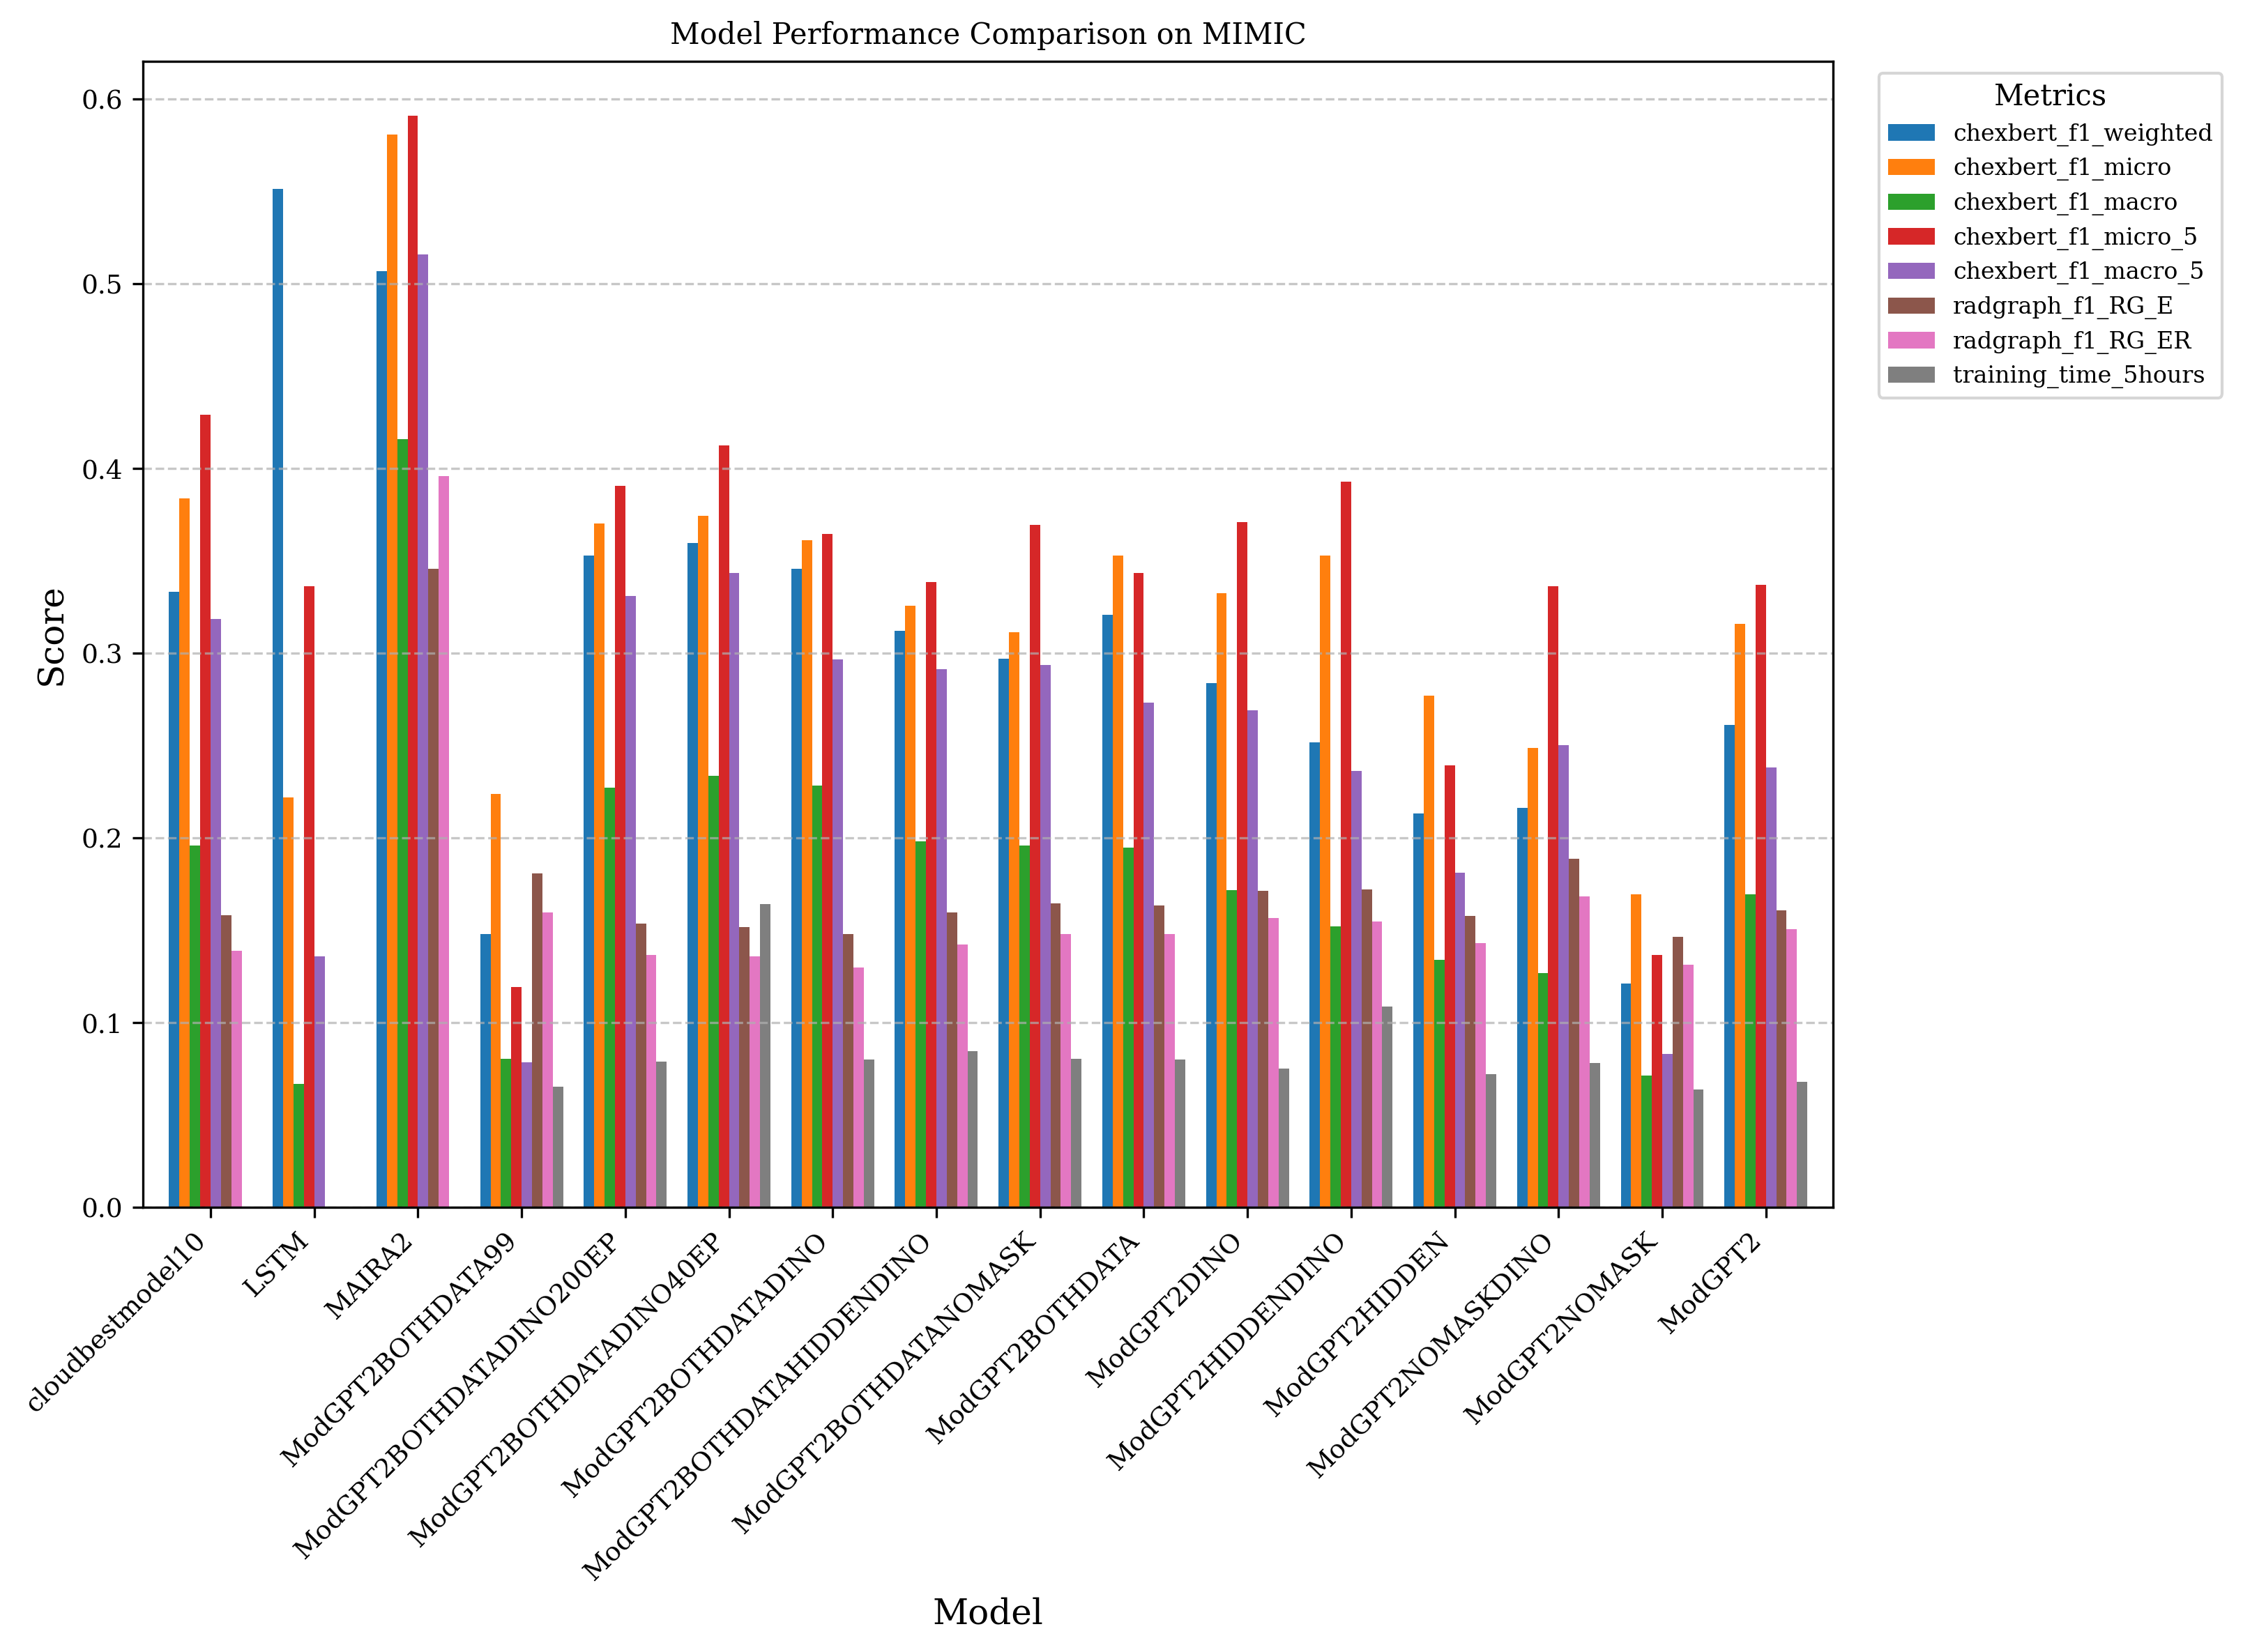

Plotting Selected MIMIC metrics...
Convirtiendo training_time_seconds a horas/5 epochs para Selected MIMIC Models...

Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en Selected MIMIC Models
                         ModGPT2  ModGPT2NOMASK  ModGPT2HIDDEN  ModGPT2DINO  ModGPT2NOMASKDINO  ModGPT2HIDDENDINO
chexbert_f1_weighted      0.2613         0.1214         0.2134       0.2838             0.2162             0.2520
chexbert_f1_micro         0.3159         0.1696         0.2773       0.3328             0.2489             0.3530
chexbert_f1_macro         0.1697         0.0715         0.1341       0.1718             0.1270             0.1522
chexbert_f1_micro_5       0.3370         0.1368         0.2394       0.3710             0.3364             0.3930
chexbert_f1_macro_5       0.2383         0.0832         0.1811       0.2692             0.2505             0.2363
radgraph_f1_RG_E          0.1609         0.1466         0.1578       0.1717             0.1888             0.17

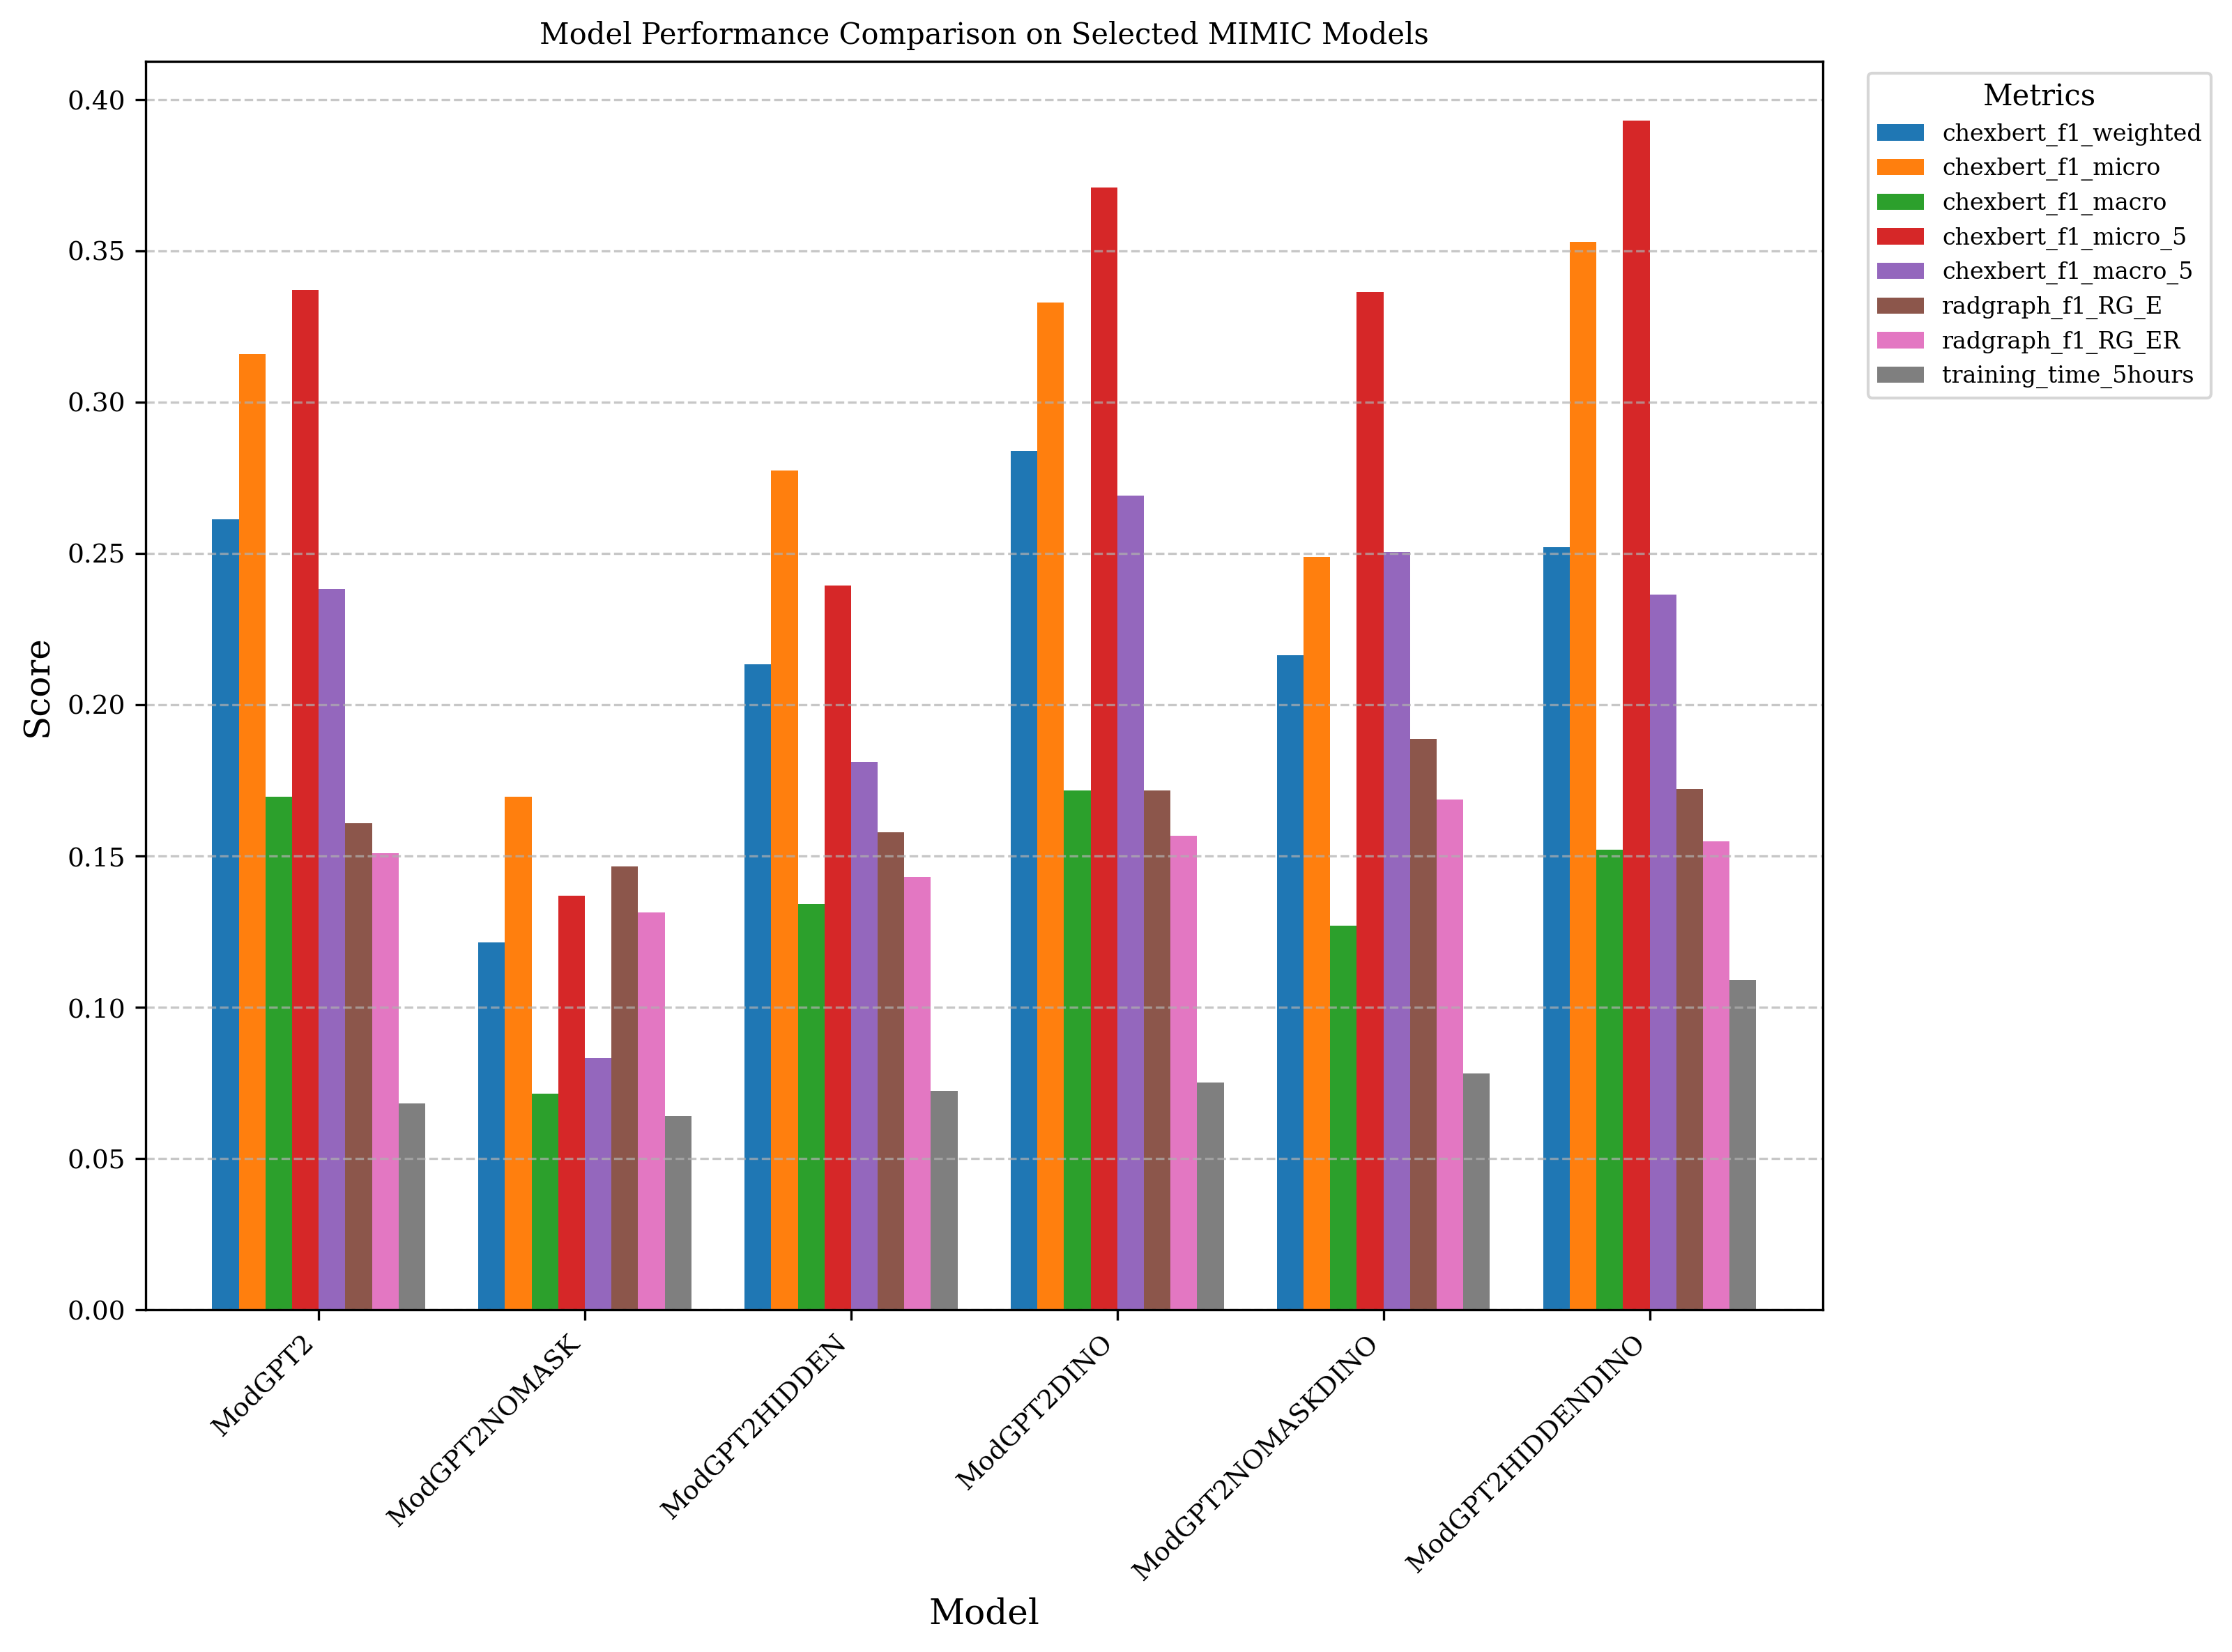

In [10]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Data from JSON Files ---
# (This loading code is the same as before)

json_paths_folder = "lstm-vs-gpt/results_complete"
json_files = [f for f in os.listdir(json_paths_folder) if f.endswith('.json')]

# Load Chexpert data
json_files_chexpert = [f for f in json_files if 'Chexpert' in f]
model_names_chexpert = [f.split('_')[0] for f in json_files_chexpert]
values_chexpert = {}
for i in range(len(model_names_chexpert)):
    model_name = model_names_chexpert[i]
    file_path = os.path.join(json_paths_folder, json_files_chexpert[i])
    try:
        with open(file_path, 'r') as f:
            values_chexpert[model_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Load MIMIC data
json_files_mimic = [f for f in json_files if 'MIMIC' in f]
model_names_mimic = [f.split('_')[0] for f in json_files_mimic]
values_mimic = {}
for i in range(len(model_names_mimic)):
    model_name = model_names_mimic[i]
    file_path = os.path.join(json_paths_folder, json_files_mimic[i])
    try:
        with open(file_path, 'r') as f:
            values_mimic[model_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Selected files
selected_json_files = ['ModGPT2_20_MIMIC.json', 'ModGPT2NOMASK_20_MIMIC.json', 'ModGPT2HIDDEN_20_MIMIC.json',
              'ModGPT2DINO_20_MIMIC.json', 'ModGPT2NOMASKDINO_20_MIMIC.json', 'ModGPT2HIDDENDINO_20_MIMIC.json']
selected_model_names = [f.split('_')[0] for f in selected_json_files]
values_selected_mimic = {}
for i in range(len(selected_model_names)):
    model_name = selected_model_names[i]
    file_path = os.path.join(json_paths_folder, selected_json_files[i])
    try:
        with open(file_path, 'r') as f:
            values_selected_mimic[model_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")


# --- 2. Plotting Function (UPDATED) ---

def plot_model_metrics(data_dict, dataset_name):
    """
    Creates a grouped bar chart and prints a formatted Pandas table for model metrics.
    
    Args:
        data_dict (dict): The dictionary {model_name: {metric: score}}.
        dataset_name (str): The name of the dataset (e.g., "MIMIC-CXR").
    """
    if not data_dict:
        print(f"No data to plot for {dataset_name}.")
        return

    # Convert the dictionary to a pandas DataFrame
    # Models are Columns, Metrics are Index (Rows)
    df = pd.DataFrame(data_dict)
    
    # Transpose for the Bar Chart: Models become Index (Rows), Metrics become Columns
    df_transposed_for_plot = df.T

    # --- Training Time Conversion ---
    if "training_time_seconds" in df_transposed_for_plot.columns:
        print(f"Convirtiendo training_time_seconds a horas/5 epochs para {dataset_name}...")
        
        # Convert seconds to hours / 5
        df_transposed_for_plot["training_time_seconds"] = df_transposed_for_plot["training_time_seconds"] / (3600 * 5)
        
        # Rename the column for the plot and the final table
        df_transposed_for_plot = df_transposed_for_plot.rename(
            columns={"training_time_seconds": "training_time_5hours"}
        )
        # Apply the rename back to the original structure 'df' too
        # df = df.rename(index={"training_time_seconds": "training_time_5hours"})
    
    # ------------------------------------------------------------
    ## 📝 Generación de Tabla (Usando Pandas)
    # ------------------------------------------------------------
    print("\n" + "="*80)
    print(f"Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en {dataset_name}")
    print("="*80)
    
    # El DataFrame 'df' ya tiene la estructura deseada:
    # Índice = Métricas
    # Columnas = Modelos
    df_final_table = df
    
    # Formato: Redondear los valores para una tabla limpia (ej. a 4 decimales)
    df_formatted = df_final_table.round(4)

    # Imprimir la tabla usando el método de impresión de Pandas (no Markdown)
    # Nota: Usamos .to_string() para asegurar que se imprima la tabla completa sin truncar columnas
    # o filas, aunque la simple impresión del DF también funciona en muchos entornos.
    print(df_formatted.to_string())
    print("="*80 + "\n")


    # ------------------------------------------------------------
    ## 📊 Generación de Gráfico
    # ------------------------------------------------------------

    # Create the grouped bar chart using the transposed DF
    ax = df_transposed_for_plot.plot(
        kind='bar', 
        figsize=(12, 8), 
        title=f'Model Performance Comparison on {dataset_name}',
        width=0.8
    )

    # --- Customize the plot ---
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Place the legend outside of the plotting area
    ax.legend(title='Metrics', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Add gridlines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent legend from being cut off
    plt.tight_layout(rect=[0, 0, 0.9, 1]) 
    
    # Display the plot
    plt.show()

# --- 3. Generate the Plots ---

print("Plotting Chexpert metrics...")
plot_model_metrics(values_chexpert, "Chexpert")

print("Plotting MIMIC metrics...")
plot_model_metrics(values_mimic, "MIMIC")

print("Plotting Selected MIMIC metrics...")
plot_model_metrics(values_selected_mimic, "Selected MIMIC Models")

✅ Extracted 20 data points for MASK-DINO.
✅ Extracted 20 data points for MASK.
✅ Extracted 20 data points for HIDDEN-MASK.
✅ Extracted 20 data points for HIDDEN-MASK-DINO.
✅ Extracted 20 data points for NO-MASK.
✅ Extracted 20 data points for NO-MASK-DINO.


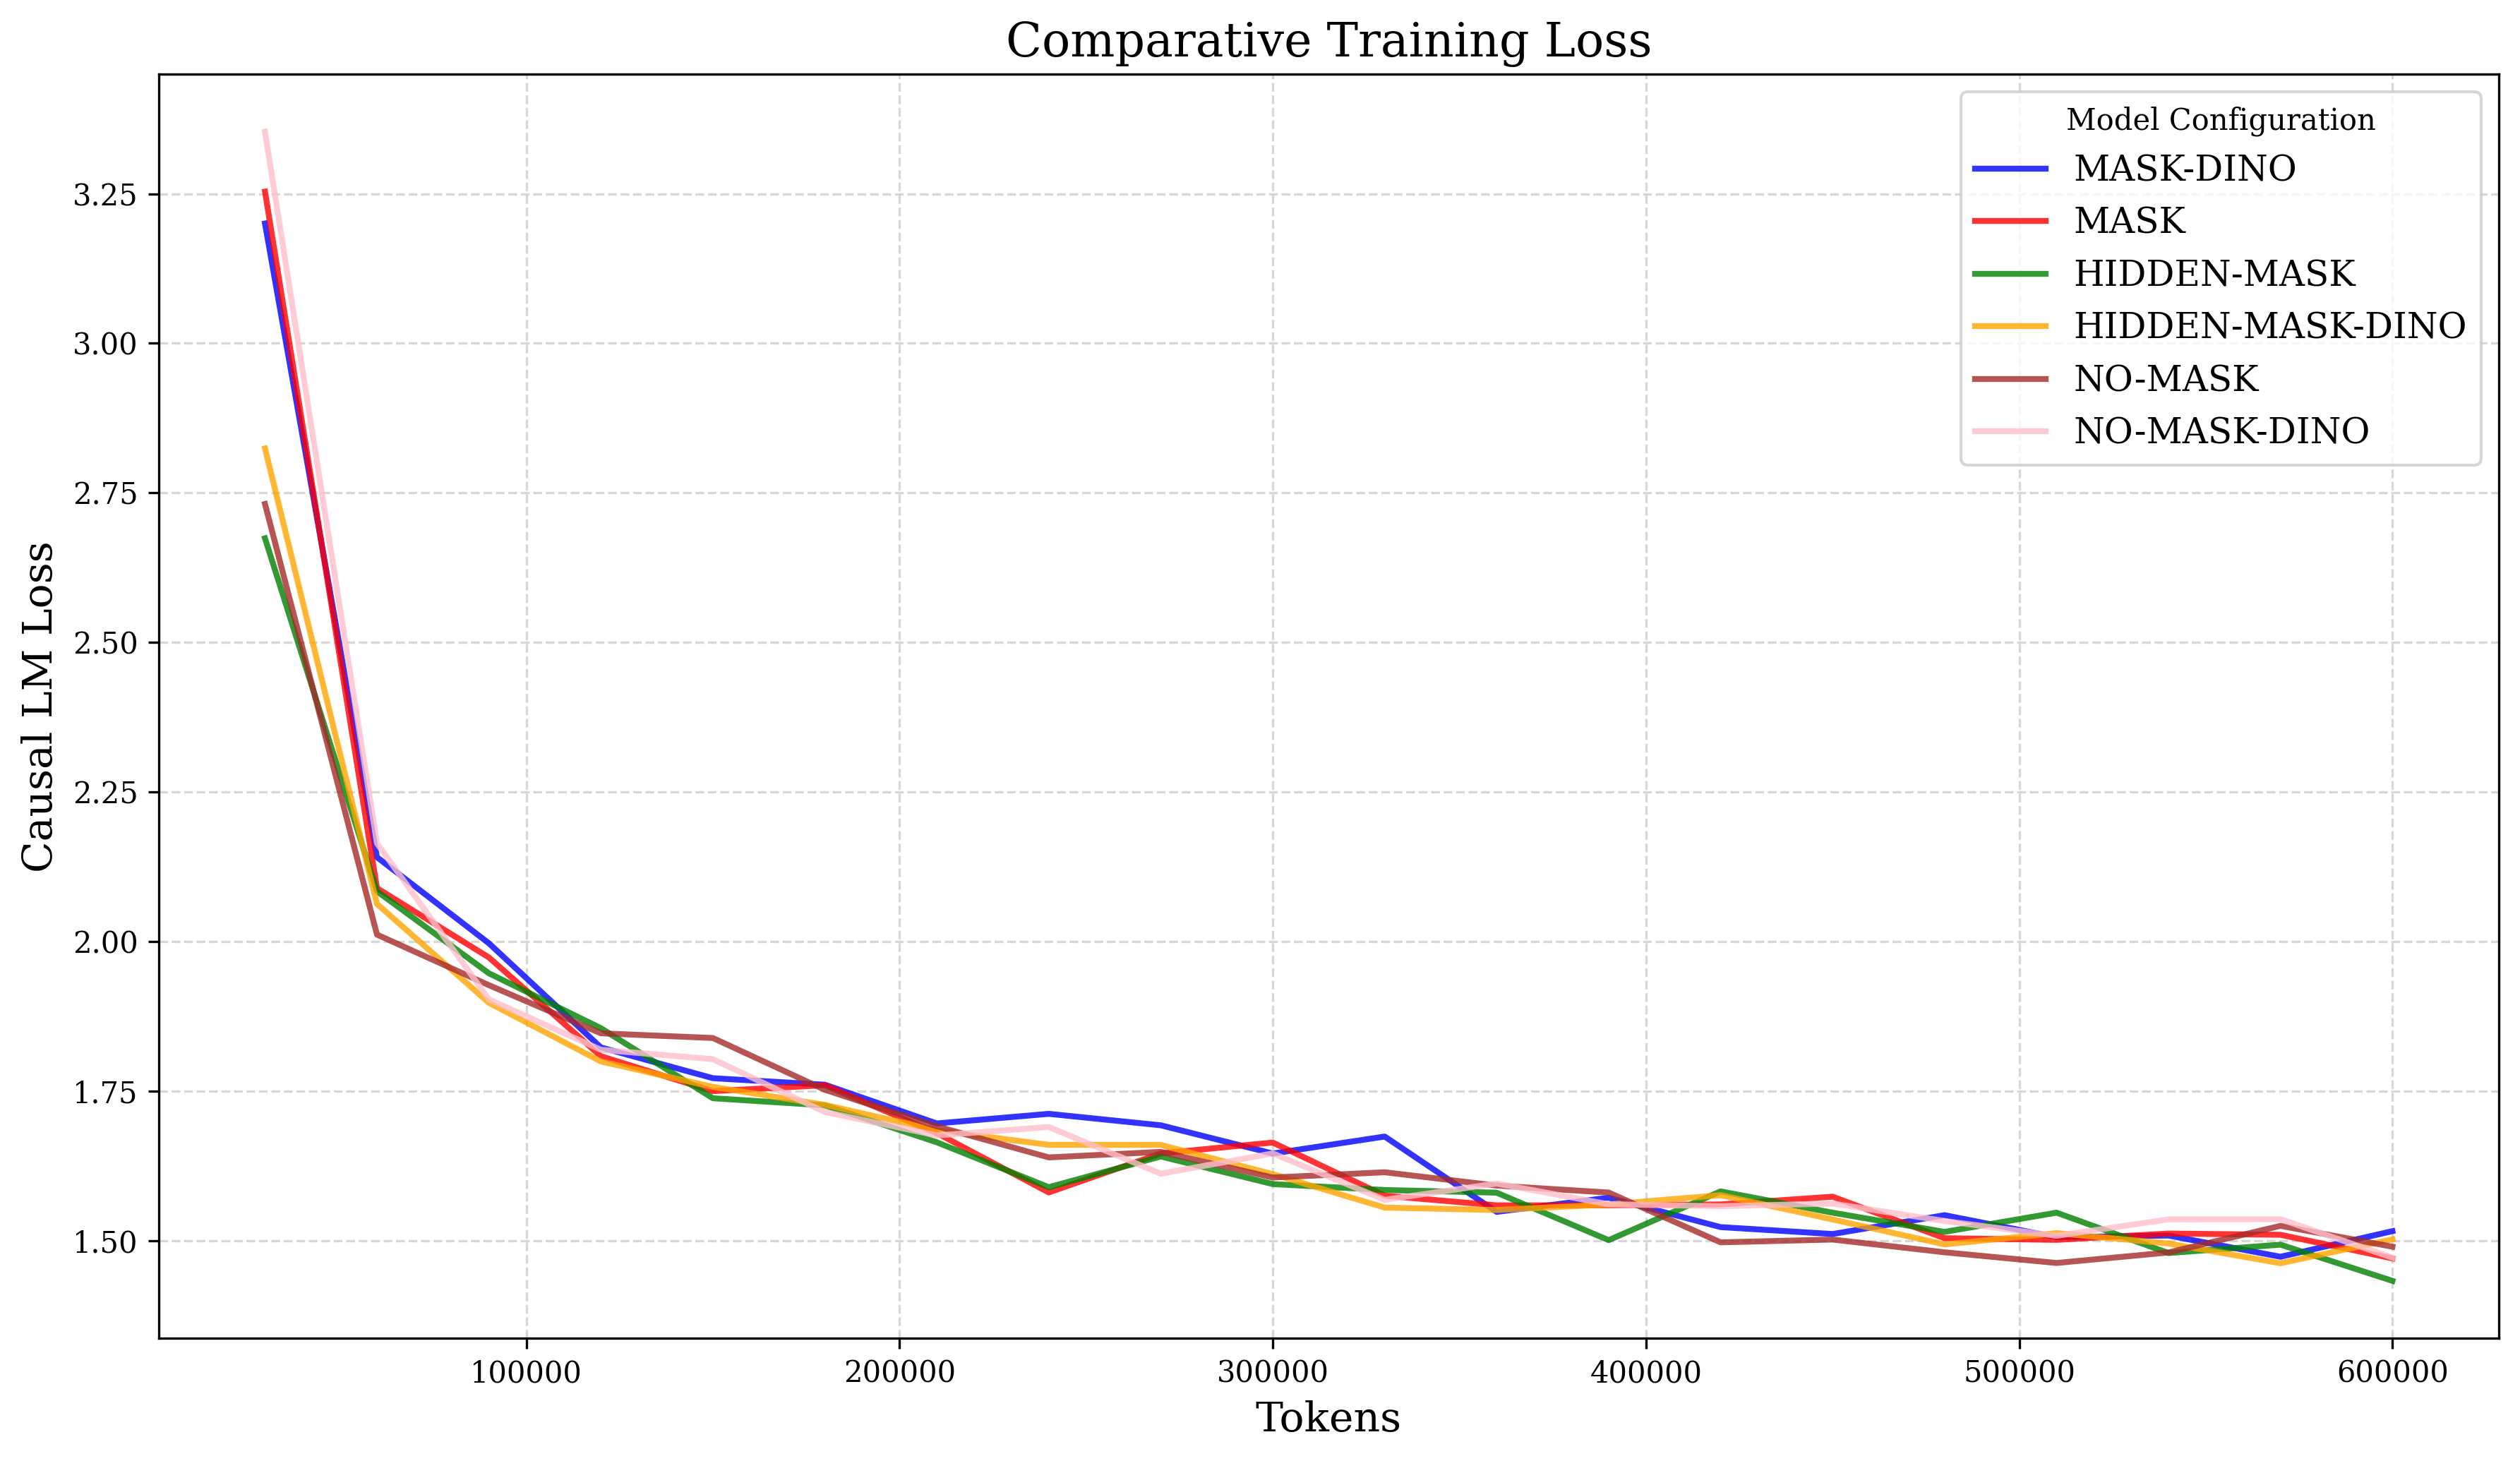

In [11]:
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import os 
import numpy as np # Used for simple list/array handling

## 🚨 Configuration You Must Adjust 🚨

# 1. Define all your event files and their corresponding plot labels
LOG_FILES = [
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2DINO_findings/events.out.tfevents.1763868601.DESKTOP_PC.167500.0',
        'label': 'MASK-DINO',  # Name to display in the legend
        'color': 'blue'
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2_findings/events.out.tfevents.1763862685.DESKTOP_PC.140616.0',
        'label': 'MASK',
        'color': 'red'
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2HIDDEN_findings/events.out.tfevents.1763921184.DESKTOP_PC.192952.0',
        'label': 'HIDDEN-MASK',
        'color': 'green'
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2HIDDENDINO_findings/events.out.tfevents.1763924080.DESKTOP_PC.68584.0',
        'label': 'HIDDEN-MASK-DINO',
        'color': 'orange'
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2NOMASK_findings/events.out.tfevents.1763857958.DESKTOP_PC.116212.0',
        'label': 'NO-MASK',
        'color': 'brown'
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2NOMASKDINO_findings/events.out.tfevents.1763932852.DESKTOP_PC.246260.0',
        'label': 'NO-MASK-DINO',
        'color': 'pink'
    }

]

# 2. Define the exact tag to extract from ALL files
# This is the loss value recorded at the end of each epoch.
LOSS_TAG = 'train/loss_epoch' 

# Define the multiplier for steps (epochs) to convert to tokens (in 100k units)
# If your steps are epochs, and 1 epoch is 300,000 tokens, then step * 0.3 = token_count_in_100k
STEP_TO_TOKEN_MULTIPLIER = 30000 


def extract_scalar_data(event_file_path, tag):
    """Reads a TensorBoard event file and extracts step and scalar values for a given tag."""
    if not os.path.exists(event_file_path):
        print(f"Error: File not found at: {event_file_path}. Skipping.")
        return None, None

    steps = []
    values = []

    # print(f"Reading file: {os.path.basename(event_file_path)}...") # Disabled for cleaner output

    try:
        for event in summary_iterator(event_file_path):
            if event.summary.value:
                for value in event.summary.value:
                    if value.tag == tag:
                        steps.append(event.step)
                        values.append(value.simple_value)
    except Exception as e:
        print(f"An error occurred while processing {event_file_path}: {e}. Skipping.")
        return None, None
        
    return steps, values

# --- Main Plotting Logic ---

plt.figure(figsize=(12, 7))
all_data_found = False

for log_info in LOG_FILES:
    file_path = log_info['path']
    label = log_info['label']
    color = log_info['color']
    
    steps, losses = extract_scalar_data(file_path, LOSS_TAG)

    if steps:
        all_data_found = True
        print(f"✅ Extracted {len(steps)} data points for {label}.")

        # Convert steps (epochs) to tokens (in 100k units)
        tokens = [step * STEP_TO_TOKEN_MULTIPLIER for step in steps]
        
        # Plot the data on the current figure
        plt.plot(
            tokens, 
            losses, 
            label=label, 
            color=color, 
            linewidth=2,
            alpha=0.8
        )
    else:
        print(f"❌ Warning: No data plotted for {label}. File path or tag incorrect.")


# --- Final Plot Customization ---

if all_data_found:
    plt.title(f'Comparative Training Loss', fontsize=16)
    plt.xlabel('Tokens', fontsize=14)
    plt.ylabel('Causal LM Loss', fontsize=14)
    
    # Improve plot appearance
    plt.legend(title='Model Configuration', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Use standard formatting for x-axis since you are scaling by 0.3 already
    # If the token count gets huge (e.g., millions), you might still use 'sci'
    # plt.ticklabel_format(style='plain', axis='x') 
    
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data could be extracted from any file. Cannot generate plot.")

✅ Extracted 20 data points for MASK-DINO.
✅ Extracted 20 data points for MASK.
✅ Extracted 20 data points for HIDDEN-MASK.
✅ Extracted 20 data points for HIDDEN-MASK-DINO.
✅ Extracted 20 data points for NO-MASK.
✅ Extracted 20 data points for NO-MASK-DINO.
Figure saved as: assets/training_loss_comparison.png


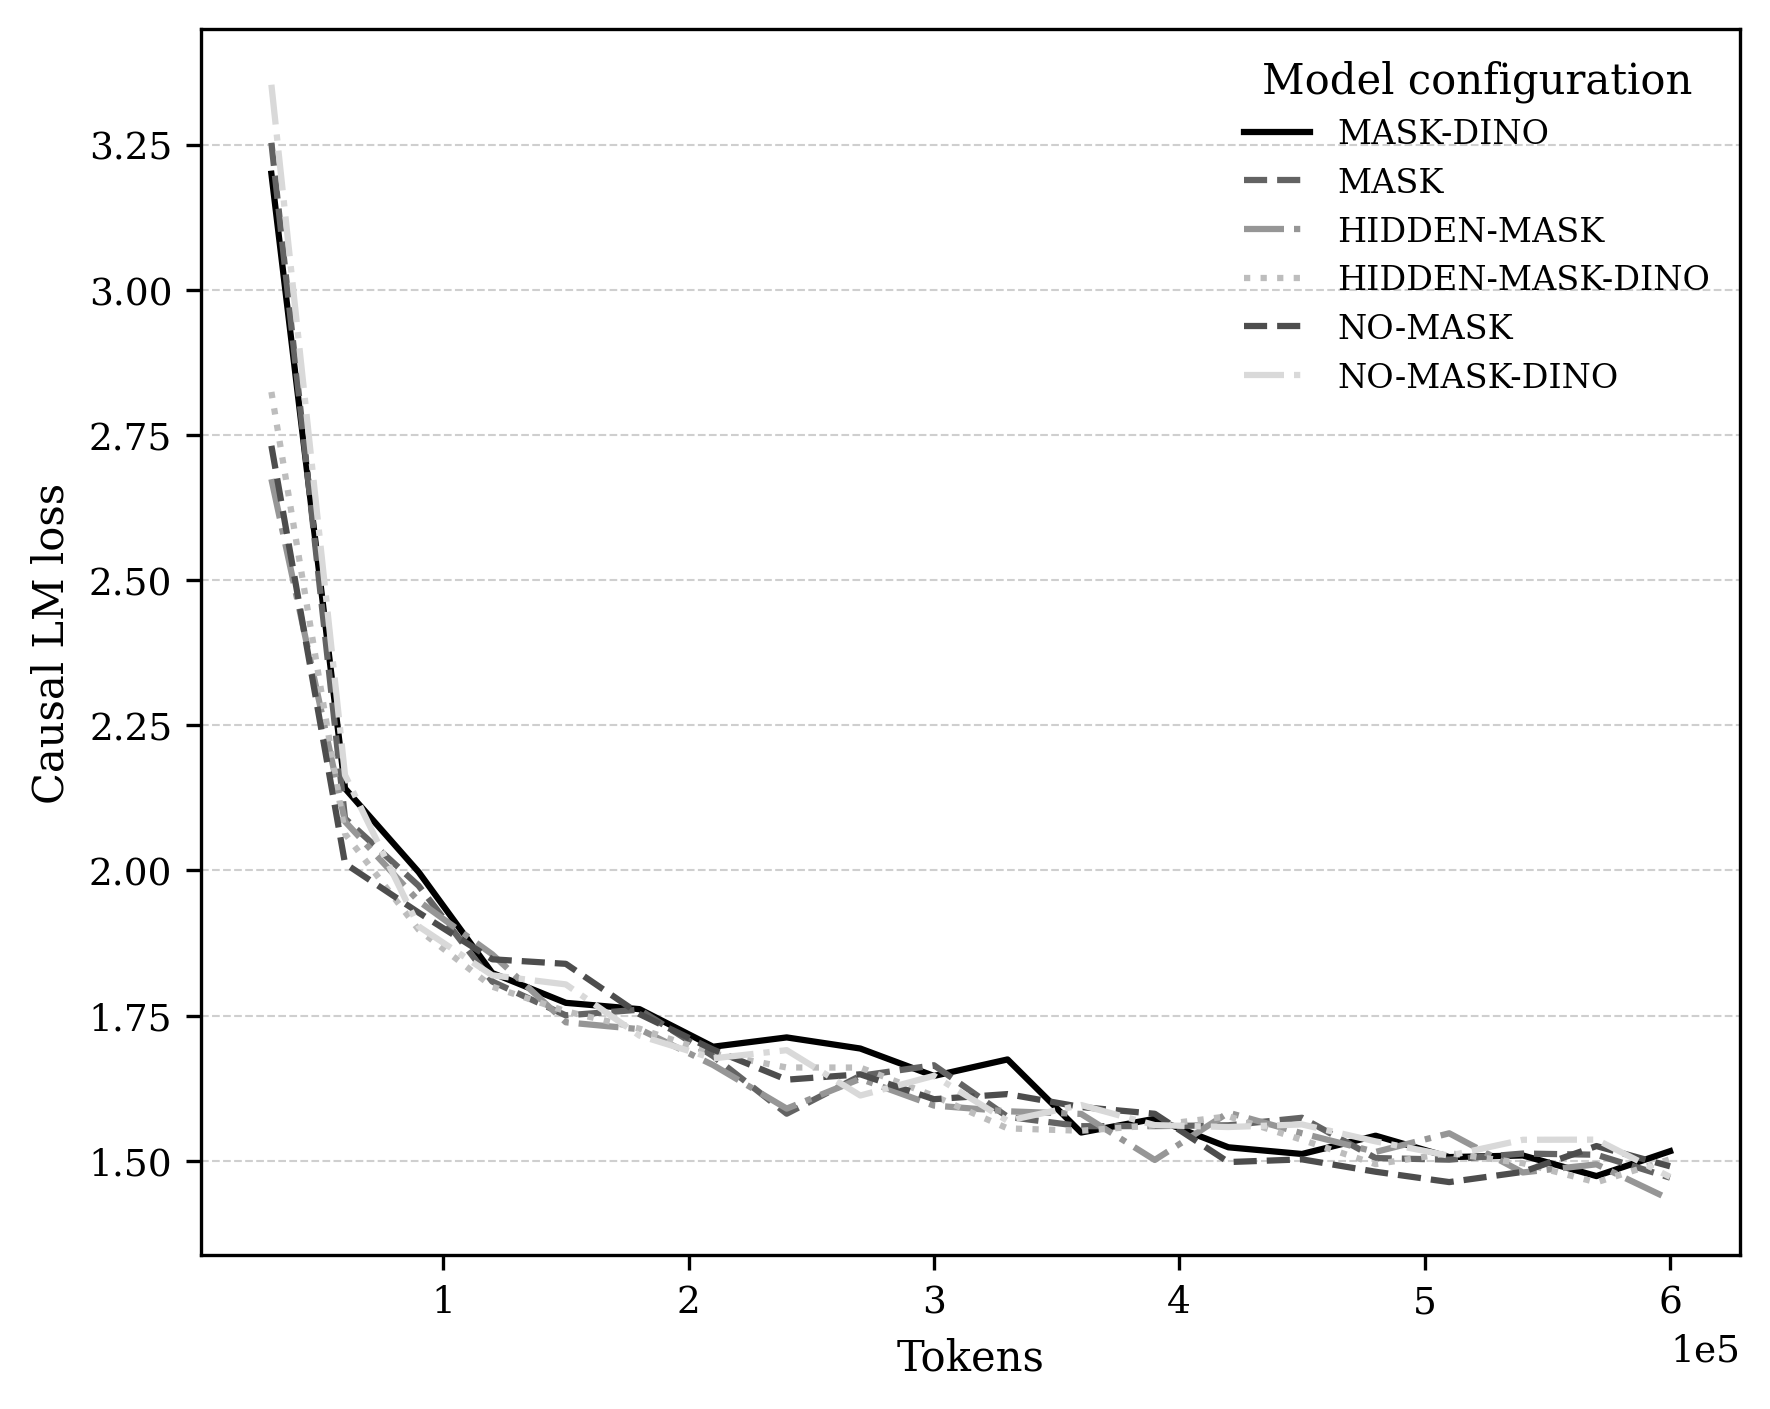

In [12]:
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# Estilo global tipo paper
# ------------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
})

# ------------------------------------------------------------
# 1. Configuración de los experimentos
# ------------------------------------------------------------

LOG_FILES = [
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2DINO_findings/events.out.tfevents.1763868601.DESKTOP_PC.167500.0',
        'label': 'MASK-DINO',
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2_findings/events.out.tfevents.1763862685.DESKTOP_PC.140616.0',
        'label': 'MASK',
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2HIDDEN_findings/events.out.tfevents.1763921184.DESKTOP_PC.192952.0',
        'label': 'HIDDEN-MASK',
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2HIDDENDINO_findings/events.out.tfevents.1763924080.DESKTOP_PC.68584.0',
        'label': 'HIDDEN-MASK-DINO',
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2NOMASK_findings/events.out.tfevents.1763857958.DESKTOP_PC.116212.0',
        'label': 'NO-MASK',
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2NOMASKDINO_findings/events.out.tfevents.1763932852.DESKTOP_PC.246260.0',
        'label': 'NO-MASK-DINO',
    }
]

LOSS_TAG = 'train/loss_epoch'

# Si 1 step = 30,000 tokens, entonces tokens = step * 30000
STEP_TO_TOKEN_MULTIPLIER = 30000


def extract_scalar_data(event_file_path, tag):
    """Reads a TensorBoard event file and extracts step and scalar values for a given tag."""
    if not os.path.exists(event_file_path):
        print(f"Error: File not found at: {event_file_path}. Skipping.")
        return None, None

    steps = []
    values = []

    try:
        for event in summary_iterator(event_file_path):
            if event.summary.value:
                for value in event.summary.value:
                    if value.tag == tag:
                        steps.append(event.step)
                        values.append(value.simple_value)
    except Exception as e:
        print(f"An error occurred while processing {event_file_path}: {e}. Skipping.")
        return None, None

    return steps, values


# ------------------------------------------------------------
# 2. Lógica principal de ploteo (formato paper)
# ------------------------------------------------------------

# Figura tipo columna de paper: más alta que tu versión original
fig, ax = plt.subplots(figsize=(6, 4.8))
all_data_found = False

# Paleta en escala de grises + estilos de línea distintos
line_colors = ['black', '#636363', '#969696', '#bdbdbd', '#4d4d4d', '#d9d9d9']
line_styles = ['-', '--', '-.', ':', '--', '-.']

for i, log_info in enumerate(LOG_FILES):
    file_path = log_info['path']
    label = log_info['label']

    steps, losses = extract_scalar_data(file_path, LOSS_TAG)

    if steps:
        all_data_found = True
        print(f"✅ Extracted {len(steps)} data points for {label}.")

        # Convert steps (epochs) to tokens
        tokens = np.array(steps, dtype=float) * STEP_TO_TOKEN_MULTIPLIER

        color = line_colors[i % len(line_colors)]
        linestyle = line_styles[i % len(line_styles)]

        ax.plot(
            tokens,
            losses,
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=1.5,
        )
    else:
        print(f"❌ Warning: No data plotted for {label}. File path or tag incorrect.")


# ------------------------------------------------------------
# 3. Acabados finales de la figura
# ------------------------------------------------------------

if all_data_found:
    # Sin título interno; el título va en la leyenda/caption del paper
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Causal LM loss')

    # Grid solo horizontal, sutil
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.set_axisbelow(True)

    # Formato científico en el eje x si es grande
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    # Leyenda arriba, estilo limpio
    ax.legend(
        title='Model configuration',
        frameon=False,
        loc='upper right',
        ncol=1
    )

    plt.tight_layout()

    # Guardar en formatos listos para paper
    png_path = "assets/training_loss_comparison.png"
    plt.savefig(png_path, bbox_inches='tight')
    print(f"Figure saved as: {png_path}")

    plt.show()
else:
    print("\nNo data could be extracted from any file. Cannot generate plot.")
